# Sampling random numbers via Metropolis Monte Carlo (MC) algorithm

## Table of Content <a name="TOC"></a>

1. [General setups](#setups)

2. [General idea of the Metropolis algorithm](#metropolis) 

3. [Particle-in-a-box distributions](#piab-1)

  3.1. [Case 3.1](#case-3.1) 
  
  3.2. [Case 3.2](#case-3.2)
  
4. [Harmonic oscillator distributions](#ho-1)
  
  4.1. [Case 4.1](#case-4.1) 
  
  4.2. [Case 4.2](#case-4.2)
  
  4.3. [Case 4.3](#case-4.3)
  

### A. Learning objectives

- to know how Metropolis algorithm works and to use it to sample coornates and momenta from Boltzmann distribution
- to use C++-level function of Libra to sample particle-in-a-box and harmonic oscillator distributions

### B. Use cases

- Wigner sampling
- Canonical ensemble sampling via Monte Carlo Sampling from arbitrary distributions
- computing probability density of the data

### C. Functions

- `liblibra::libmontecarlo`
  - [`metropolis_gau`](#metropolis_gau-1) | [also here](#metropolis_gau-2)

  
### D. Classes and class members

- `liblibra::libdata`
  - [`DATA`](#DATA-1)
    - [`Calculate_Distribution`](#Calculate_Distribution-1)
    
- `liblibra::librandom`
  - [`Random`](#Random-1)
    - [`uniform`](#uniform-1)    
    - [`normal`](#normal-1)


## 1. General setups
<a name="setups"></a> [Back to TOC](#TOC)

In [1]:
import math
import sys
import cmath
import math
import os

if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *
import util.libutil as comn

from libra_py import units
import matplotlib.pyplot as plt   # plots
#matplotlib.use('Agg')
#%matplotlib inline 

import numpy as np
#from matplotlib.mlab import griddata

plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=20)      # fontsize of the x and y labels
plt.rc('legend', fontsize=20)     # legend fontsize
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

colors = {}

colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<float, std::all

## 2. General idea of the Metropolis algorithm
<a name="metropolis"></a>[Back to TOC](#TOC)

If we are to sample random numbers from a distribution $P(z_n)$, where $z$ is a generalized argument, then the Metropolis algorithm generates a sequence of random numbers (random walk), $z_0 -> z_1 -> ... z_n -> z_{n+1} -> ..$
such that:

moves $z_n -> z_{n+1}$ are accepted with the probability $\frac{P(z_{n+1})}{P(z_{n})}$

In our case, the target probability density if proportional to the system's partition function:

$$P(q, p) = \frac{1}{Z} exp(-\frac{H(q, p)}{k_B T})$$ where, $$H(q,p) = \frac{p^2}{2m} + V(q)$$ is the system's Hamiltonian, $v(q)$ is the potential energy, $Z$ is the partition function. In this example, we consider a 1D particle, so there is only 1 degree of freedom, so $\frac{p^2}{2m}$ is the kinetic energy. More to that - we set the particle's mass to 1.0

Also, the potential is assumed to be quadratic: $$V(q) = \frac{\omega^2 q^2}{2}  + \omega \sqrt \frac{E_r}{2} q$$, where $E_r$ is the reorganization energy.

Thus, the proposed transitions $(q_n, p_n) -> (q_{n+1}, p_{n+1})$ are accepted with the probability:

$$ \frac{P(q_{n+1}, p_{n+1})}{P(q_{n}, p_{n})} = exp(-\frac{H_{n+1} - H_n}{k_B T})$$

Each sampling makes a sifficient number of steps to avoid any "memory" effects, although one could have simply run a single very long simulations and just discart a certain number of first steps of the process. This would likely save some extra time and should be considered in more complex situations.
<a name="uniform-1"></a><a name="normal-1"></a>

In [2]:
def boltz(params, rnd):
    # This function generates x and p taken from the Boltzmann distribution

    Er = params["Er"]
    omega = params["omega"]
    kT = params["kT"]    
    
    mo2 = 0.5*omega*omega # mass = 1
    M = math.sqrt(mo2*Er)


    X_ = -0.5*M/mo2             # minimum
    p_ = math.sqrt(kT)          # momentum that corresponds to temperatures
    x_ = X_ + 50.0*rnd.normal() # + 0.5*(M/mo2)*rnd.normal()  #(M/mo2)*

    
    Eold = mo2*x_*x_ + M*x_ + 0.5*p_*p_    # energy
    Enew = 0.0


    for i in range(1000):
        # Propose a move
        x = x_ + 10.0*rnd.uniform(-1.0, 1.0) 
        p = p_ + 1.1*math.sqrt(kT)*rnd.uniform(-1.0, 1.0) 

        # Compute the energy at the proposed coordinates
        Enew = mo2*x*x + M*x + 0.5*p*p
        
        # Accept or reject the proposed moves stochastically
        # based on the energy difference and temperature
        dE = Enew - Eold
        ksi = rnd.uniform(0.0,1.0)
        prob = 1.0
        argg = dE/kT
        if argg >40:
            prob = 0.0
        elif argg < -40:
            prob = 1.0
        else: 
            prob = math.exp(-dE/kT)  #min(1.0, math.exp(-dE/kT))

        if(ksi<prob):  # accept new state with Metropolis scheme
            Eold = Enew
            x_ = x
            p_ = p

    return [x_, p_]

Sample the coordinates and momenta from Boltzmann distribution using the Metropolis MC algorithm implemented above.

Note how the `boltz` functions is called 5000 times to sample 5000 random numbers. In each call, there are 1000 steps of the process. We could potentially considered 5000 + 1000 individual steps, with the initial 5000 steps being discarded. 
<a name="Random-1"></a>

In [3]:
# Define it only once
rnd = Random()

params = {}
params["Er"] = Er = 2.39e-2
params["omega"] = omega = 3.5e-4
params["kT"] = kT = 9.5e-4

mo2 = 0.5*omega*omega # mass = 1
M = math.sqrt(mo2*Er)
x_ = -0.5*M/mo2           # position of the minimum
p_ = math.sqrt(kT)        # momentum that corresponds to temperatures


x, p = [], []
for i in range(0,5000):    
    [a, b] = boltz( params, rnd )
    x.append(a)
    p.append(b)


Compute the grids in coordinate and momentum spaces and compute the distributions
<a name="DATA-1"></a><a name="Calculate_Distribution-1"></a>

In [4]:
ax = []
spread = 500.0
dx = 2.0*spread / 100.0
for i in range(0,100):   
    ax.append(x_ - spread + i*dx)

px = []
spread = 1.0*math.sqrt(kT)
dp = 4.0*spread / 100.0
for i in range(0,100):   
    px.append(-2.0*math.sqrt(kT) + i*dp)


X = DATA(x)
P = DATA(p)
    
Xdens = X.Calculate_Distribution(ax)[0]
Pdens = P.Calculate_Distribution(px)[0]

Compute the analytical distributions and normalize both the analytical and sampled distributions.

In [5]:
sz = len(ax)

prob_x, prob_px = [], []
for i in range(0, sz):
    prob = math.exp(-( mo2*ax[i]*ax[i] + M*ax[i] + 0.5*p_*p_ )/kT)
    prob_x.append(prob)
    
    prob = math.exp(-( mo2*x_*x_ + M*x_ + 0.5*px[i]*px[i] )/kT) 
    prob_px.append(prob)
    
Z_analyt = sum(prob_x) * dx
Z_sampled = sum(Xdens) * dx

Z_analyt_p = sum(prob_px) * dp
Z_sampled_p = sum(Pdens) * dp


for i in range(0, sz):
    prob_x[i] = prob_x[i] / Z_analyt
    Xdens[i] = Xdens[i] / Z_sampled    
    
    prob_px[i] = prob_px[i] / Z_analyt_p
    Pdens[i] = Pdens[i] / Z_sampled_p

Fianlly plot the results

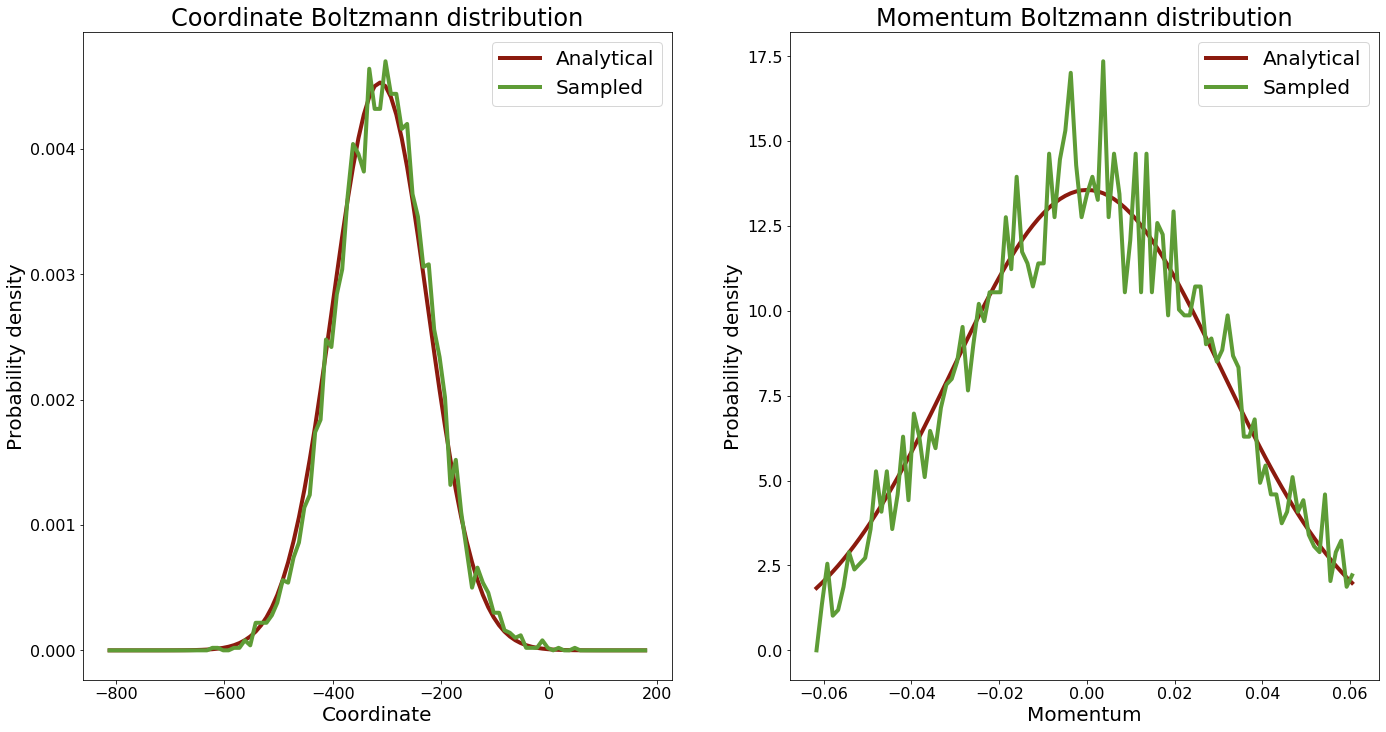

In [6]:
plt.figure(1, figsize=(24,12) )
plt.subplot(1, 2, 1)
plt.title('Coordinate Boltzmann distribution')
plt.xlabel('Coordinate')
plt.ylabel('Probability density')
plt.plot(ax, prob_x, label='Analytical', linewidth=4, color = colors["11"]) 
plt.plot(ax, Xdens, label='Sampled', linewidth=4, color = colors["21"]) 
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Momentum Boltzmann distribution')
plt.xlabel('Momentum')
plt.ylabel('Probability density')
plt.plot(px, prob_px, label='Analytical', linewidth=4, color = colors["11"]) 
plt.plot(px, Pdens, label='Sampled', linewidth=4, color = colors["21"]) 
plt.legend()

plt.show()
plt.close()

## 3. Particle-in-a-box distributions
<a name="piab-1"></a>[Back to TOC](#TOC)

<a name="metropolis_gau-1"></a>
In this and the next sections, we will demonstrate the usage of the `metropolis_gau` function. This function implements a generalization of the algorithm shown in the `boltz` function of Section 2.

This function has the following signature:

    vector<MATRIX> metropolis_gau(Random& rnd, bp::object target_distribution, MATRIX& dof, bp::object distribution_params, int sample_size, int start_sampling, double gau_var)
    
Here:

* `rnd` - is the random number generator object
* `target_distribution` is a Python function that computes the probability distribution function and that would be passed to C++ (called by the C++ code) and should be defined by the user. It should have the following signature:


      double target_distribution(MATRIX& dof, bp::object params);


* `dof` - the starting coordinates of the random walker. It is stored in the MATRIX format so that the calculations are possible for arbitrary dimensions.
* `distribution_params` a dictionary of parameters for the distribution function defined by the user
* `sample_size` how many multidimensional points to sample from the distribution, this determines the length of the Gaussian random walk
* `start_sampling` how many first moves to disregard before starting collecting the data
* `ksi` is the Gaussian variance - the scaling factor for the stepping in various dimensions. If it is too large, we may be not accepting too many moves, because the chances are we will be in a reagion with a very different probability density, so the the chances of the acceptance may be small. Such moves would also make the sampling coarser, so the neat features may be lost. For the distributions with higher fluctuations, use smaller step size value. However, the space exploration process may be slow then, so one may need using larger number of steps.
    

Here, we start by defining a function returning the PDF the user wants to sample random numbers from. 

In this example, we define the probability density for 1D particle-in-a-box states - one of the standard problems encountered in nearly any quantum mechanics course. 

Note that the function is defined with the signature above:

    double target_distribution(MATRIX& dof, bp::object params);
    
Inside, we unpack the coordinate vector and the parameters of the function and use them to compute the results.

In [7]:
def piab(q, params):
    """
    The probability density function

    """

    L = params["L"]
    n = params["n"]

    x = q.get(0)

    p = 0.0
    if x>0.0 and x<L:
        p = (2.0/L)*(math.sin(x*n*math.pi/L))**2

    return p

We also define an auxiliary function that analyzes the computed points, creates the bins as defined by the user and counts the numbers of points in each bin, to compute the probabilities sampled. 

This function also does the visualization of the results, for convenience of the following steps.

In [8]:
def make_bin(sample, min_, max_, dx, i, j, my_label):
    """
    An auxiliary function to compute the bins
    """

    # Prepare the grids
    x_points, y_points = [], []
    max_pts = int((max_ - min_)/dx) + 1

    for n in range(max_pts):
        x_points.append(min_ + n * dx)
        y_points.append(0.0)

    # Compute the frequencies
    sz = len(sample)
    for n in range(sz):
        x = sample[n].get(i,j) 
        indx = int((x - min_)/dx)

        y_points[indx] = y_points[indx] + 1.0/float(sz)
              
    
    plt.figure(1, figsize=(24,12) )
    plt.title(my_label)
    plt.xlabel('Coordinate')
    plt.ylabel('Probability density')
    plt.plot(x_points, y_points, label='', linewidth=4, color = colors["11"]) 
    plt.legend()
    plt.show()
    plt.close()


Finally, we can explore several cases, but simply calling the metropolis_gau functions with the corrsponding parameters and then passing the sampled data to the `make_bin` function

### Case 3.1.
<a name="case-3.1"></a>[Back to TOC](#TOC)

No handles with labels found to put in legend.


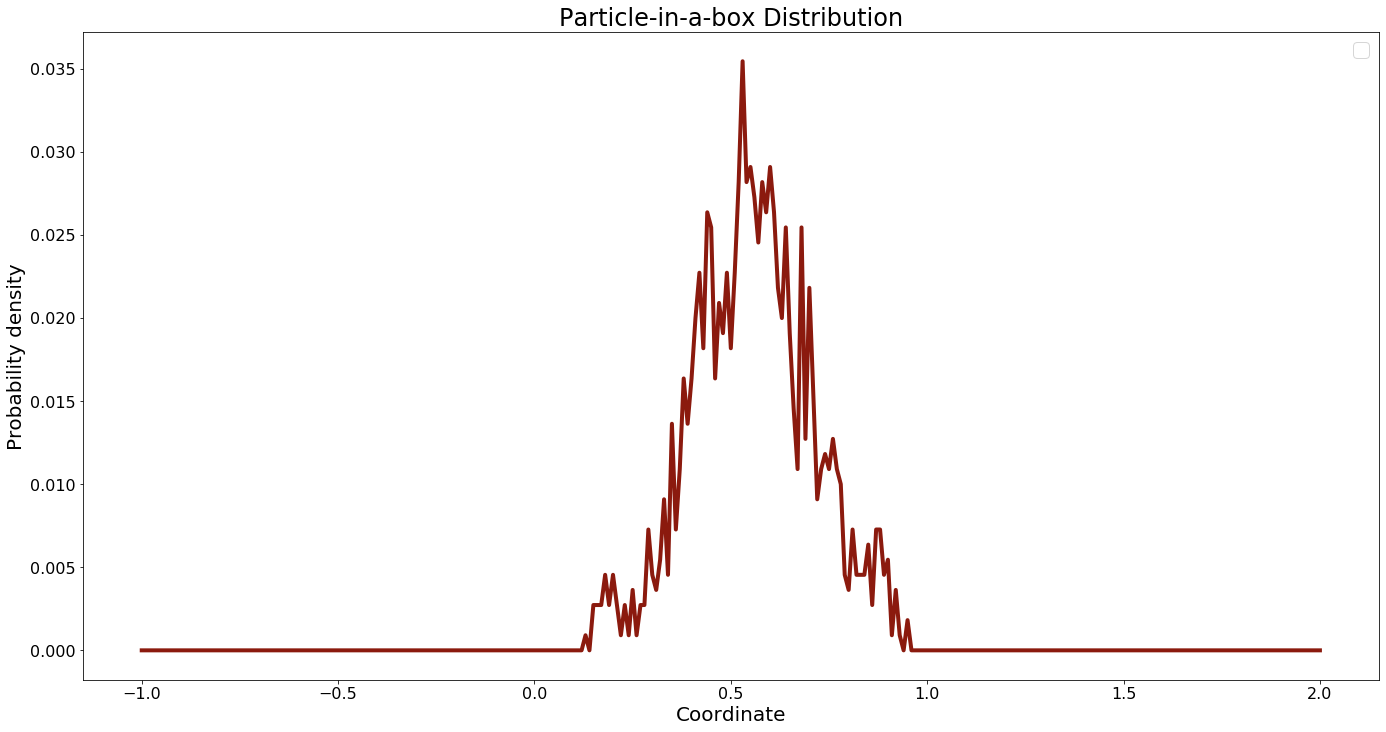

In [9]:
rnd = Random()
my_label = "Particle-in-a-box Distribution"

q = MATRIX(1,1);  q.set(0, 0.5)   
sample = metropolis_gau(rnd, piab, q, {"L":1.0, "n":1} , 1100, 10, 0.05) 
make_bin(sample, -1.0, 2.0, 0.01, 0, 0, my_label)    

To make it smoother, we decrease the stepping size, but also include more steps to sample.

No handles with labels found to put in legend.


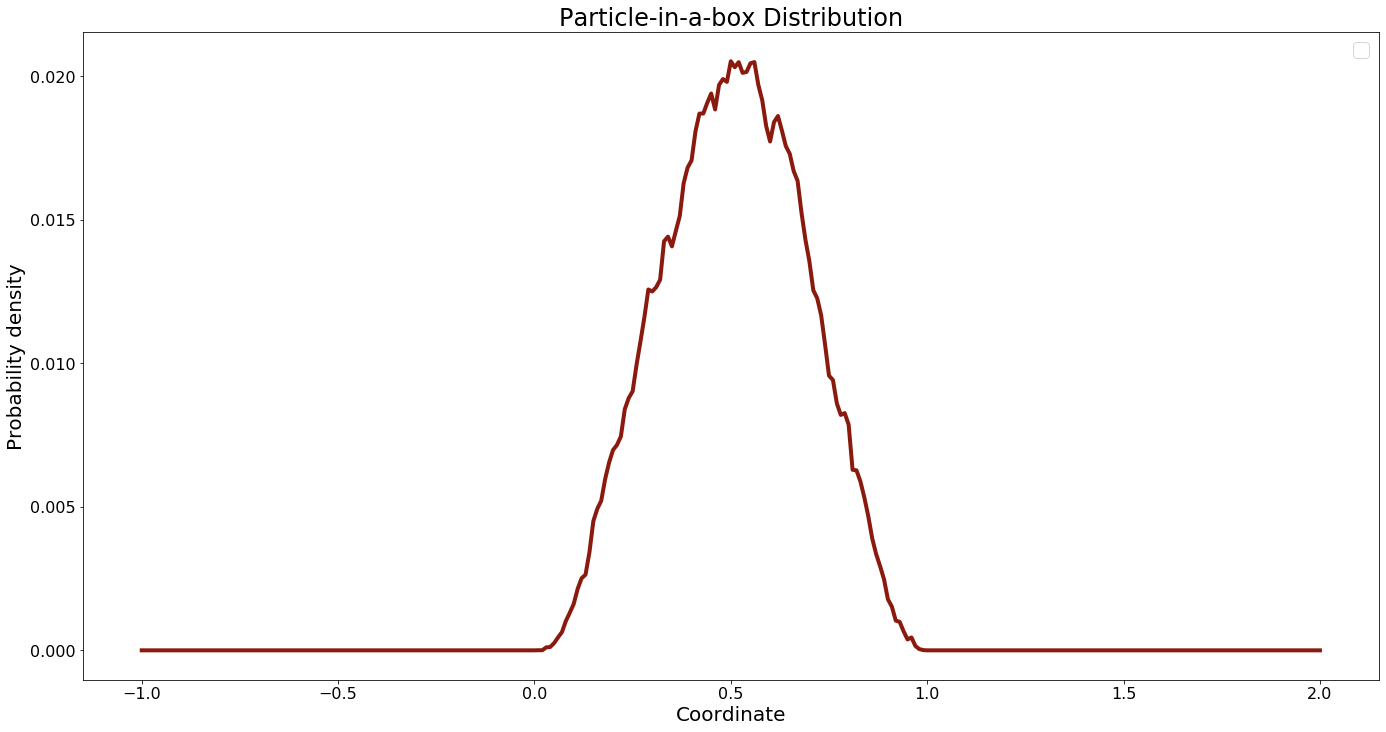

In [10]:
q.set(0, 0.5)   
sample = metropolis_gau(rnd, piab, q, {"L":1.0, "n":1} , 250000, 25000, 0.01) 
make_bin(sample, -1.0, 2.0, 0.01, 0, 0, my_label)    

### Case 3.2.
<a name="case-3.2"></a>[Back to TOC](#TOC)

Now, let's use a really large number of steps, but play with the quantum number of the piab state:

### n = 2

No handles with labels found to put in legend.


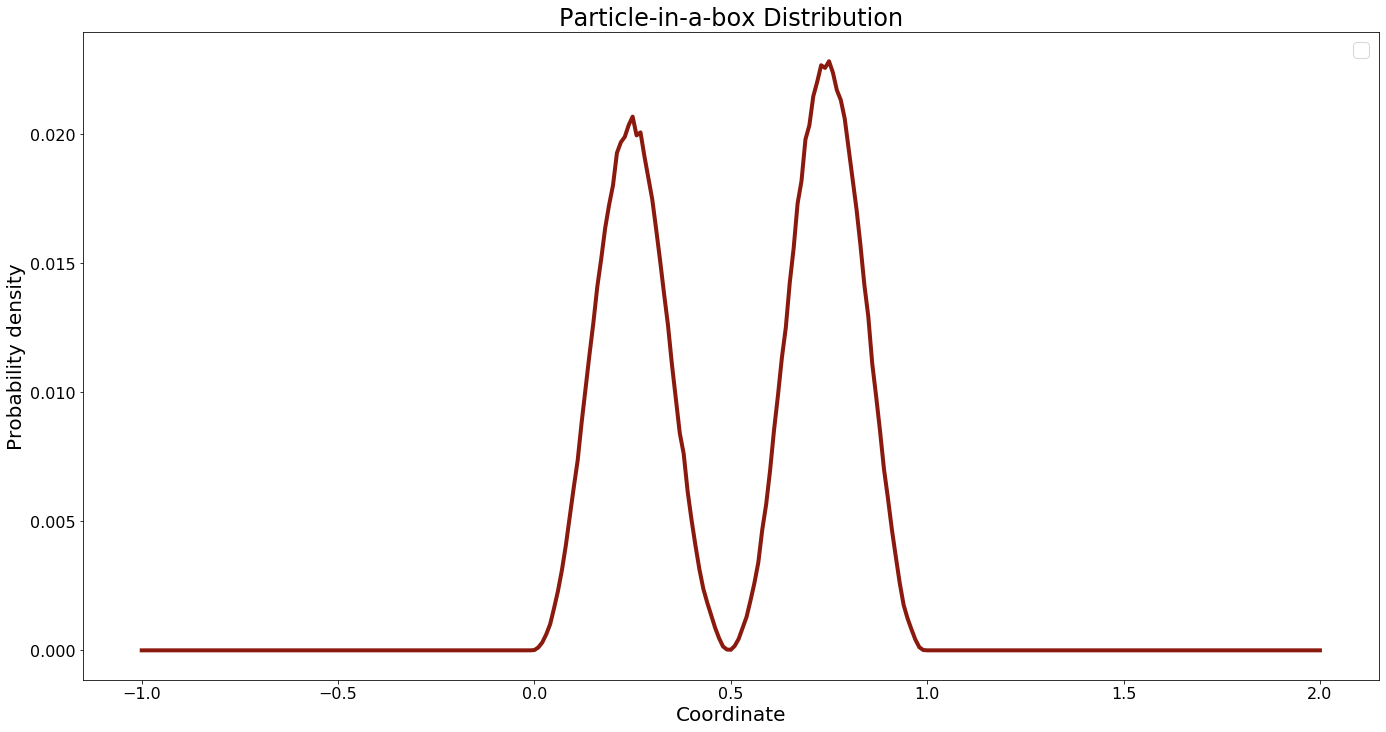

In [11]:
q.set(0, 0.5)   
sample = metropolis_gau(rnd, piab, q, {"L":1.0, "n":2} , 500000, 25000, 0.05) 
make_bin(sample, -1.0, 2.0, 0.01, 0, 0, my_label)    

### n = 5

No handles with labels found to put in legend.


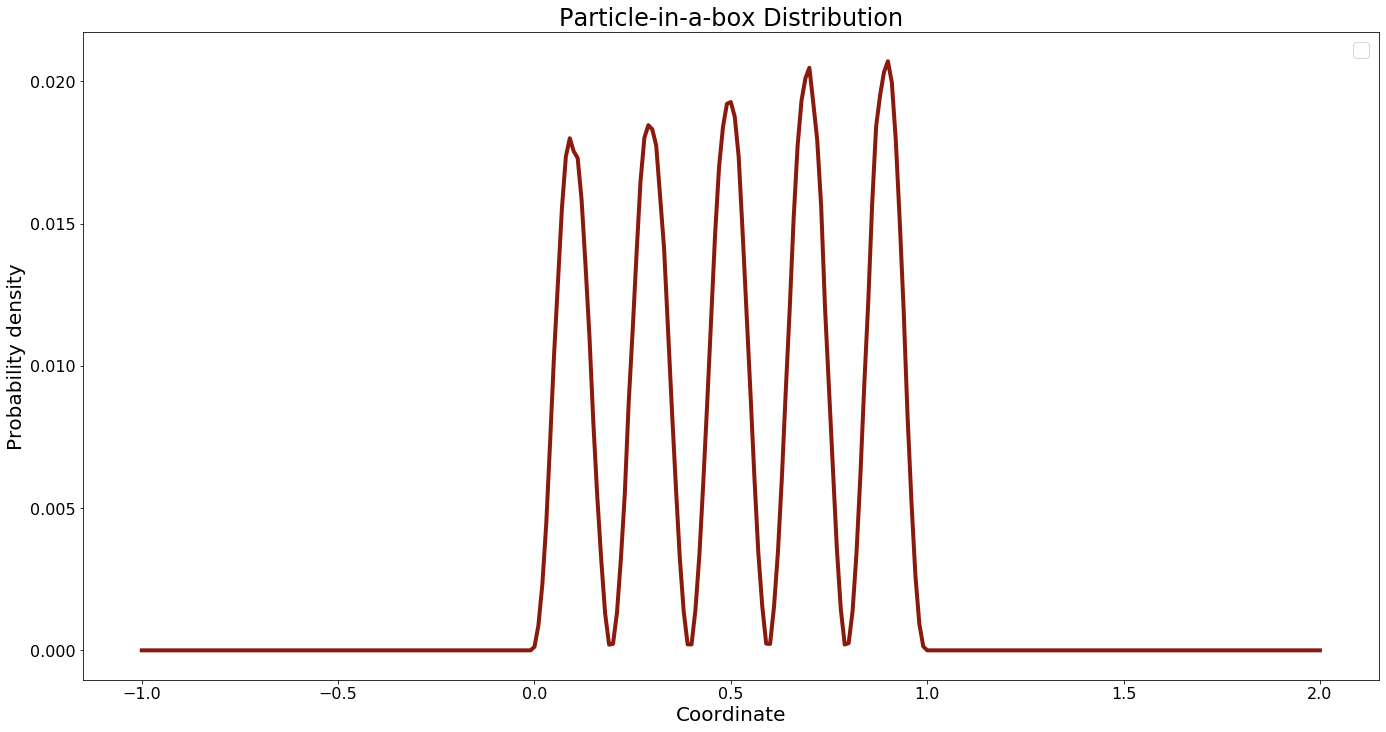

In [12]:
q.set(0, 0.5)   
sample = metropolis_gau(rnd, piab, q, {"L":1.0, "n":5} , 500000, 25000, 0.05) 
make_bin(sample, -1.0, 2.0, 0.01, 0, 0, my_label)    

### n = 10

No handles with labels found to put in legend.


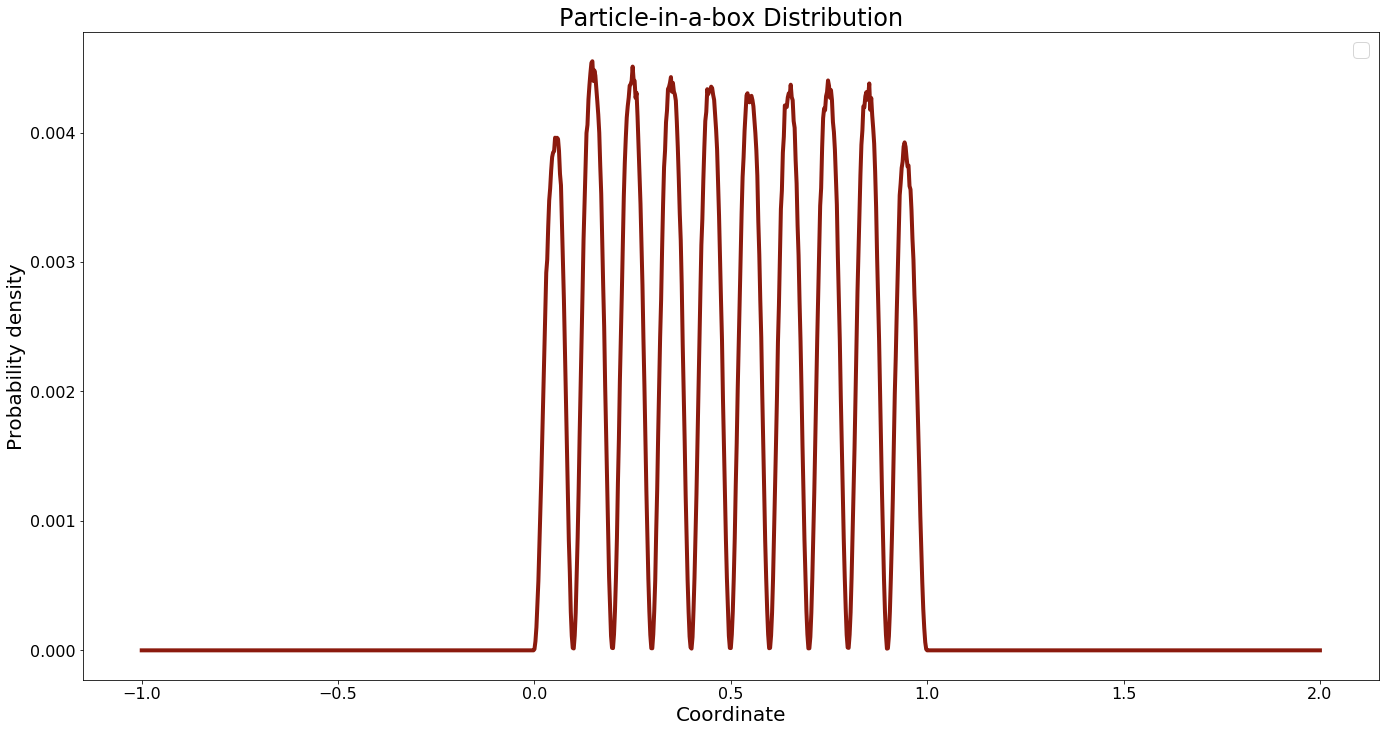

In [13]:
q.set(0, 0.5)   
sample = metropolis_gau(rnd, piab, q, {"L":1.0, "n":10} , 2500000, 25000, 0.05) 
make_bin(sample, -1.0, 2.0, 0.0025, 0, 0, my_label)    

Note that as we increase the complexity of the distribution we also have to increase the number of sampled points, as well as the resolution of the grid we are looking at. Still, the sampling is a bit off on the edges. 

## 4. Harmonic oscillator distributions
<a name="ho-1"></a>[Back to TOC](#TOC)

Now, let's consider sampling random numbers from the probability densities of a harmonic oscillator states 

In [14]:
def hermite(n, x):
    r,s,t = 0.0, 0.0, 0.0
    p,q = 1.0, 0.0

    for m in range(n):
        r,s = p,q
        p = 2.0*x*r - 2.0*m*t
        q = 2.0*(m+1)*r
        t = r

    return p


def ket_n(q, n, k, m):
    """
    HO state |n>
    """

    hbar = 1.0  # atomic units
    omega = math.sqrt(k/m)  
    alp = m*omega/hbar

    N_n =  math.pow(alp/math.pi, 0.25) / math.sqrt(math.pow(2.0, n) * FACTORIAL(n))
    ksi = math.sqrt(alp)*q    
    H_n = hermite(n, ksi)
 
    res = N_n * H_n * math.exp(-0.5*ksi*ksi)

    return res
        

def HO_sup(q, params):
    """
    The probability density function: superposition of HO eigenstates

    """

    k = params["k"]
    m = params["m"]
    states = params["states"]
    coeffs = params["coeffs"]

    x = q.get(0)

    sz = len(states)
    p = 0.0
    for n in range(sz):
        p = p + coeffs[n] * ket_n(x, states[n], k, m)

    p = p * p 

    return p


def HO_sup_t(q, params, t):
    """
    The probability density function: superposition of HO eigenstates

    now, time-dependent

    |Psi> = \sum_n {  c_n * |n> * exp(-i*t*E_n/hbar) }

    """

    k = params["k"]
    m = params["m"]
    states = params["states"]
    coeffs = params["coeffs"]

    hbar = 1.0  # atomic units
    omega = math.sqrt(k/m)  


    x = q.get(0)

    sz = len(states)
    p = 0.0+0.0j
    for n in range(sz):
        E_n = hbar*omega*(n+0.5)
        p = p + coeffs[n] * ket_n(x, states[n], k, m) * cmath.exp(-1.0j*t*E_n/hbar)

    p = (p.conjugate() * p ).real

    return p


### Case 4.1. Sampling $|0>$
<a name="case-4.1"></a>[Back to TOC](#TOC)
<a name="metropolis_gau-2"></a>

No handles with labels found to put in legend.


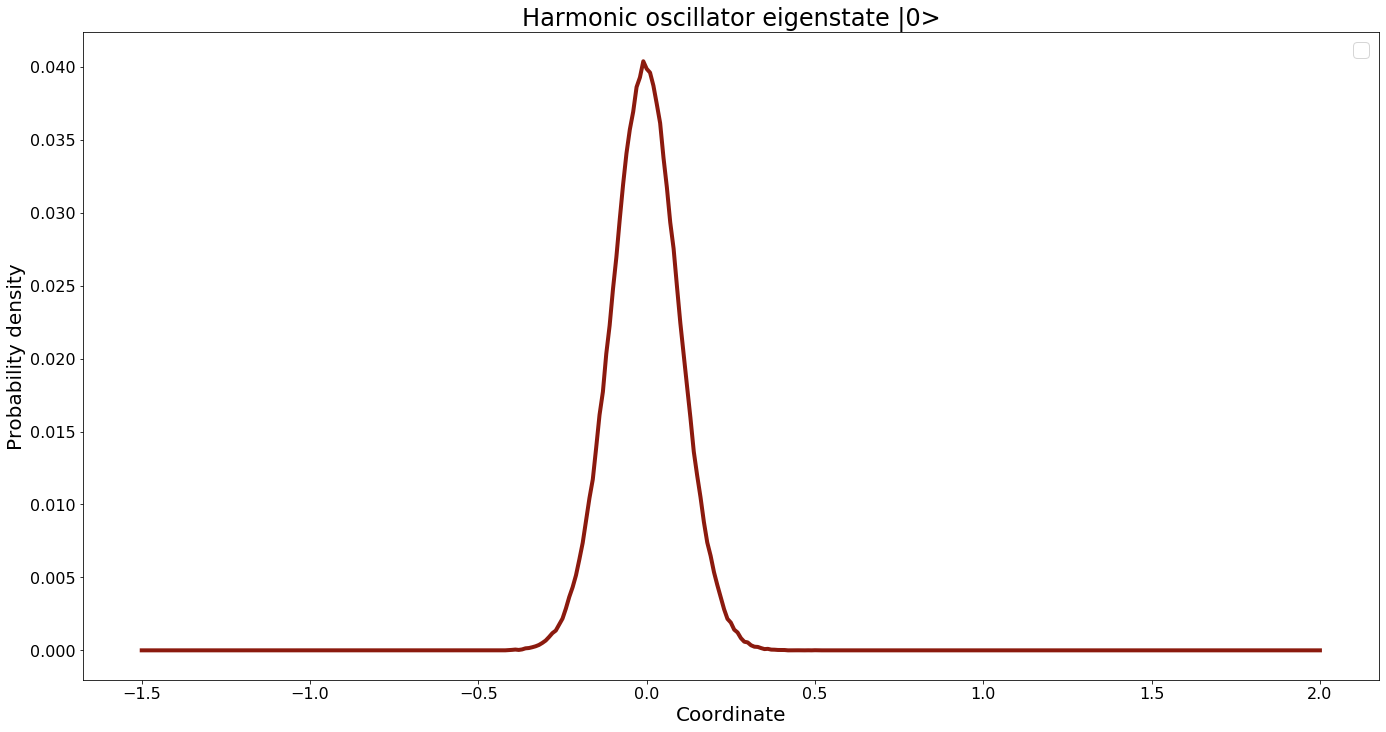

In [15]:
rnd = Random()

q = MATRIX(1,1);  q.set(0, 0.5)    
params = {"k":1.0, "m":2000.0, "states":[0], "coeffs":[1.0]}    
sampling = metropolis_gau(rnd, HO_sup, q, params, 500000, 50000, 0.05) 
make_bin(sampling, -1.5, 2.0, 0.01, 0, 0, "Harmonic oscillator eigenstate |0>")    

### Case 4.2. Sampling $|10>$
<a name="case-4.2"></a>[Back to TOC](#TOC)

No handles with labels found to put in legend.


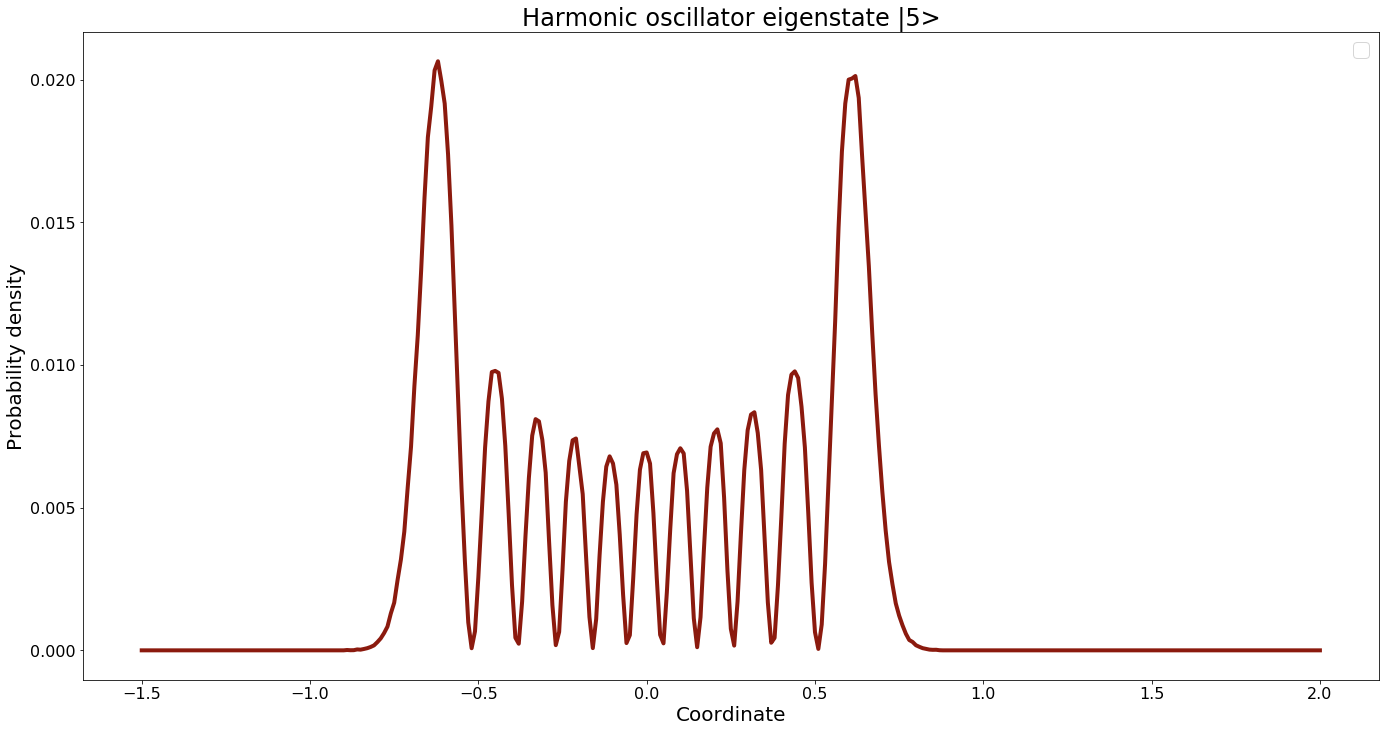

In [16]:
q = MATRIX(1,1);  q.set(0, 0.5)    
params = {"k":1.0, "m":2000.0, "states":[10], "coeffs":[1.0]}    
sampling = metropolis_gau(rnd, HO_sup, q, params, 500000, 50000, 0.05) 
make_bin(sampling, -1.5, 2.0, 0.01, 0, 0, "Harmonic oscillator eigenstate |5>")

### Case 4.3. Sampling $|0> - |1>$
<a name="case-4.3"></a>[Back to TOC](#TOC)

No handles with labels found to put in legend.


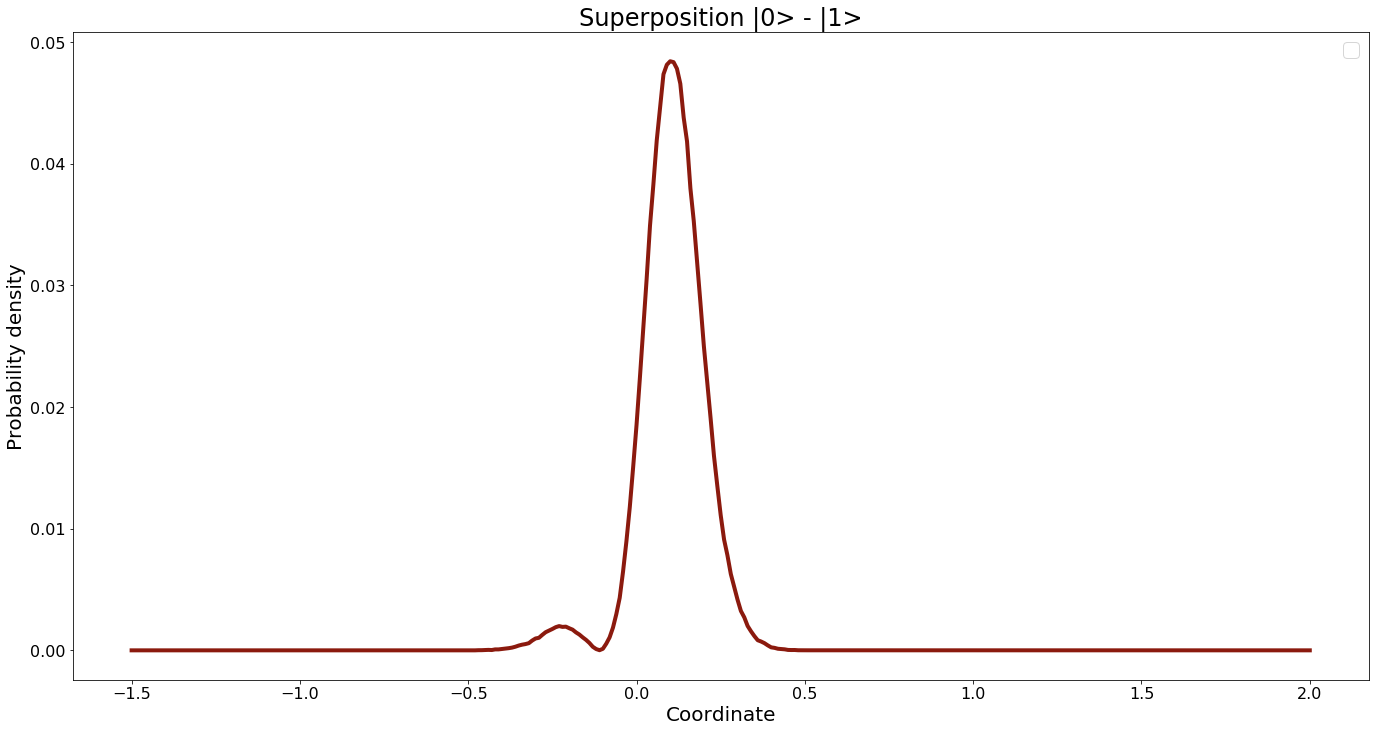

In [17]:
q = MATRIX(1,1);  q.set(0, 0.5)    
params = {"k":1.0, "m":2000.0, "states":[0, 1], "coeffs":[1.0, 1.0]}    
sampling = metropolis_gau(rnd, HO_sup, q, params, 500000, 50000, 0.05) 
make_bin(sampling, -1.5, 2.0, 0.01, 0, 0, "Superposition |0> - |1>")